In [163]:
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt

Data Generator

In [164]:
matrix_a = np.array([[1, 1], [0, 1]])
matrix_b = np.array([[1, -1], [0, 1]])
matrix_c = np.array([[1, 0], [-1, 1]])
matrix_d = np.array([[1, 0], [1, 1]])

inverse_a = np.array([[1, -1], [0, 1]])
inverse_b = np.array([[1, 1], [0, 1]])
inverse_c = np.array([[1, 0], [1, 1]])
inverse_d = np.array([[1, 0], [-1, 1]])

def data_generator(num_points):
    data = []
    max_moves = 30
    end_position = np.array([[random.randint(1, 11),0]]) 
    last_move = 5
    for i in range(num_points):
        current_position = end_position
        moves = random.randint(1, max_moves)
        for q in range(moves):
            coin = random.randint(0,3)
            if coin == 0 and last_move != 1: 
                current_position = current_position @ inverse_a
                last_move = 0 
            if coin == 1 and last_move != 0: 
                current_position = current_position @ inverse_b
                last_move = 1 
            if coin == 2 and last_move != 3: 
                current_position = current_position @ inverse_c
                last_move = 2 
            if coin == 3 and last_move != 2: 
                current_position = current_position @ inverse_d
                last_move = 3 
        last_move_array = np.array([0,0,0,0])
        if last_move == 0: 
            last_move_array = np.array([1, 0, 0, 0 ])
        if last_move == 1: 
            last_move_array = np.array([0, 1, 0, 0 ])
        if last_move == 2: 
            last_move_array = np.array([0, 0, 1, 0 ])
        if last_move == 3: 
            last_move_array = np.array([0, 0, 0, 1])
        current_position = np.append(current_position, last_move_array)
        data.append(current_position.tolist())
    return data

Turn to CSV using Pandas

In [165]:
data_pd = pd.DataFrame(data_generator(200000))
data_pd.to_csv("generated_pairs.csv", index = False)

Turn CSV file to tensor

In [166]:
data = pd.read_csv("generated_pairs.csv", names=["0","1","2", "3", "4", "5"], delimiter=",")
dataset = torch.utils.data.TensorDataset(
    torch.tensor(data.loc[:, "0":"1"].values,dtype=torch.float32), # input 
    torch.tensor(data.loc[:, "2":"5"].values, dtype = torch.float32) #output 
)
X, Y = dataset[:] #label input and output 

Make the Model

In [167]:
X

tensor([[  0.,   1.],
        [  7., -16.],
        [-49., -19.],
        ...,
        [ 59.,  50.],
        [ 14.,  17.],
        [  7.,  25.]])

In [168]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step 
model = nn.Sequential(
    nn.Linear(2, 128), #first layer 128
    nn.ReLU(),
    nn.Linear(128,64), #second layer 64
    nn.ReLU(),
    nn.Linear(64, 16), #third layer 16
    nn.ReLU(),
    nn.Linear(16,4), #singular output 
    nn.Sigmoid()
)

for name, param in model.named_parameters():
    print(f"Layer: {name}, Data Type: {param.dtype}")

loss_function = nn.CrossEntropyLoss() #should this be our loss function too? 
optimizer = optim.Adam(model.parameters(), lr = 0.02) #chose Adam and lr from site 

Layer: 0.weight, Data Type: torch.float32
Layer: 0.bias, Data Type: torch.float32
Layer: 2.weight, Data Type: torch.float32
Layer: 2.bias, Data Type: torch.float32
Layer: 4.weight, Data Type: torch.float32
Layer: 4.bias, Data Type: torch.float32
Layer: 6.weight, Data Type: torch.float32
Layer: 6.bias, Data Type: torch.float32


Training Model

In [169]:
num_epochs = 200
num_batches = 10 

In [170]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
        X_batch = X[i:i+num_batches]
        # print(X_batch)
        y_pred = model(torch.Tensor(X_batch))
        Y_batch = Y[i:i+num_batches]
        loss = loss_function(y_pred, torch.Tensor(Y_batch))
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f'Finished epoch {epoch}, latest loss {total_loss / len(data)}')

Finished epoch 0, latest loss 7.254126994593298e-05
Finished epoch 1, latest loss 6.61210050206234e-05
Finished epoch 2, latest loss 6.283432388751982e-05
Finished epoch 3, latest loss 6.453536727315295e-05
Finished epoch 4, latest loss 6.53023038533756e-05
Finished epoch 5, latest loss 6.122125741176027e-05
Finished epoch 6, latest loss 6.17996627610055e-05
Finished epoch 7, latest loss 6.298472890007453e-05
Finished epoch 8, latest loss 6.59031928562815e-05
Finished epoch 9, latest loss 6.697067332820532e-05
Finished epoch 10, latest loss 6.730745874888484e-05
Finished epoch 11, latest loss 6.727147918101046e-05
Finished epoch 12, latest loss 6.722252553497822e-05
Finished epoch 13, latest loss 6.737004569715006e-05
Finished epoch 14, latest loss 6.747153282628057e-05
Finished epoch 15, latest loss 6.737064293270453e-05
Finished epoch 16, latest loss 6.744966816376093e-05
Finished epoch 17, latest loss 6.73408848665443e-05
Finished epoch 18, latest loss 6.73786007090396e-05
Finished 

In [173]:
def euclidean_algorithm(pair): 
    a = pair[0]
    b = pair[1]
    plt.plot(a.detach(), b.detach(), "ro", markersize = 3)
    index = 1
    old_matrix = np.array([[1, 1], [1, 1]])

    
    while index < 100: 
        
        index += 1
        if a==0 or b==0: 
            return
        pred = float(torch.argmax(model(torch.tensor([[a,b]]))))
        print(index , ",",  pred)
        if pred == 0: # if first index has biggest value 
            if not np.array_equal(old_matrix , matrix_b):
                pair = pair @ matrix_a
                old_matrix = matrix_a
        if pred == 1: # if second index has biggest value
            if not np.array_equal(old_matrix , matrix_a):
                pair = pair @ matrix_b
                old_matrix = matrix_b
        if pred == 2: # if third index has biggest value
            if not np.array_equal(old_matrix , matrix_d):
                pair = pair @ matrix_c
                old_matrix = matrix_c
        if pred == 3: # if fourth index has biggest value
            if not np.array_equal(old_matrix ,matrix_c):
                pair = pair @ matrix_d
                old_matrix = matrix_d

        print(pair)
        a = float(pair[0])
        b = float(pair[1])
        plt.plot(a, b, "ro", markersize = 3+index) #from cs544 notes 

2 , 3.0
tensor([15., 20.], dtype=torch.float64)
3 , 1.0
tensor([15.,  5.], dtype=torch.float64)
4 , 1.0
tensor([ 15., -10.], dtype=torch.float64)
5 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
6 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
7 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
8 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
9 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
10 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
11 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
12 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
13 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
14 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
15 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
16 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
17 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
18 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
19 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
20 , 0.0
tensor([ 15., -10.], dtype=torch.float64)
21 , 0.0
tensor([ 15., -10.], dtype=torch.f

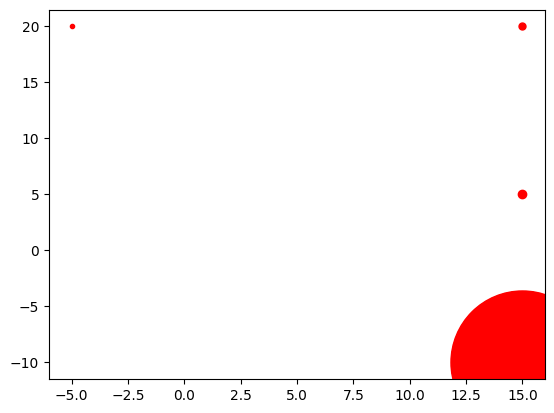

In [174]:
pair = torch.tensor([-5,20], dtype=torch.float32)
print(euclidean_algorithm(pair))
print(model(pair))
print(float(torch.argmax(model(pair))))